In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the tokenizer and model (just the embedding layer)
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
model = AutoModelForMaskedLM.from_pretrained("google/muril-base-cased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_layer = model.get_input_embeddings().to(device)


# Load GloVe Twitter embeddings (200D)
EMBEDDING_DIM = embedding_layer.embedding_dim

# Load dataset
def load_data(filename):
    with open(filename, encoding="utf-8") as file:
        return json.load(file)

# Create PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, data):
        self.labels = [[item["labels"]["l1"], item["labels"]["l2"], item["labels"]["l3"]] for item in data]
        self.tokenized = [tokenizer.encode(item["text"], add_special_tokens=False) for item in data]

    def __len__(self):
        return len(self.tokenized)

    def __getitem__(self, idx):
        input_ids = torch.tensor([self.tokenized[idx]]).to(device)
        embeddings = embedding_layer(input_ids).squeeze(0)
        return embeddings, torch.tensor(self.labels[idx], dtype=torch.float32)


# Custom Collate Function for Padding
def collate_fn(batch):
    sequences, labels = zip(*batch)

    max_len = max(seq.shape[0] for seq in sequences)

    padded_sequences = [
        torch.cat([seq, torch.zeros((max_len - seq.shape[0], EMBEDDING_DIM), device=seq.device)], dim=0)
        for seq in sequences
    ]

    return torch.stack(padded_sequences), torch.stack(labels)



Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# Assuming the functions and variables like `TextDataset`, `collate_fn`, `load_data`, `EMBEDDING_DIM`, and `device` are already defined

# Create DataLoader
def dataloader_from_json(filename):
    sentences = load_data(filename)
    dataset = TextDataset(sentences)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return dataloader

train_filename = "/kaggle/input/gender-based-abuse-dataset/final_train.json"
val_filename = "/kaggle/input/gender-based-abuse-dataset/final_test.json"
train_dataloader = dataloader_from_json(train_filename)
val_dataloader = dataloader_from_json(val_filename)

# Define RNN Model
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)  # Add Layer Normalization
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.rnn(x)
        hidden = self.layer_norm(hidden[-1])  # Normalize hidden state
        return self.sigmoid(self.fc(hidden))

# Initialize Model
model = RNNClassifier(input_dim=EMBEDDING_DIM, hidden_dim=128, output_dim=3).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Loop
num_epochs = 12

# Lists to store accuracy for each epoch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    for batch, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float().cpu().numpy()
        true_labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(true_labels)

    train_f1 = f1_score(all_labels, all_preds, average="macro")
    train_acc = accuracy_score(all_labels, all_preds)

    train_f1s.append(train_f1)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    val_loss = 0

    with torch.no_grad():
        for batch, labels in val_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float().cpu().numpy()
            true_labels = labels.cpu().numpy()

            val_preds.extend(preds)
            val_labels.extend(true_labels)

    val_f1 = f1_score(val_labels, val_preds, average="macro")
    val_acc = accuracy_score(val_labels, val_preds)

    val_f1s.append(val_f1)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {epoch_loss:.4f}, Train Acc = {train_acc:.4f}, Train F1 = {train_f1:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}")

# Plot Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/accuracy_plot.png")  # Save plot if on Kaggle
plt.show()

torch.save(model, "/kaggle/working/gbad_model_rnn.pth")
print("Training complete!")




Epoch 1/12: 100%|██████████| 608/608 [03:20<00:00,  3.03it/s]


Epoch 1: Train Loss = 408.7102, Train Acc = 0.2706, Train F1 = 0.2377, Val Loss = 78.5880, Val Acc = 0.0903, Val F1 = 0.2424


Epoch 2/12:  53%|█████▎    | 325/608 [01:46<01:32,  3.06it/s]

Epoch 1/12: 100%|██████████| 118/118 [00:38<00:00,  3.07it/s]


Epoch 1: Train Loss = 80.5990, Train Acc = 0.2133, Train F1 = 0.3475, Val Loss = 79.0777, Val Acc = 0.1521, Val F1 = 0.4354


Epoch 2/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 2: Train Loss = 79.2573, Train Acc = 0.2234, Train F1 = 0.3336, Val Loss = 78.6492, Val Acc = 0.1481, Val F1 = 0.4463


Epoch 3/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 3: Train Loss = 78.3787, Train Acc = 0.2176, Train F1 = 0.3672, Val Loss = 78.2829, Val Acc = 0.2791, Val F1 = 0.2196


Epoch 4/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 4: Train Loss = 78.4355, Train Acc = 0.2501, Train F1 = 0.3495, Val Loss = 78.3316, Val Acc = 0.3414, Val F1 = 0.1606


Epoch 5/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 5: Train Loss = 78.4734, Train Acc = 0.2684, Train F1 = 0.3084, Val Loss = 78.3250, Val Acc = 0.3427, Val F1 = 0.2711


Epoch 6/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 6: Train Loss = 78.5284, Train Acc = 0.2320, Train F1 = 0.3333, Val Loss = 78.2869, Val Acc = 0.3680, Val F1 = 0.1588


Epoch 7/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 7: Train Loss = 78.5046, Train Acc = 0.2953, Train F1 = 0.3289, Val Loss = 78.2501, Val Acc = 0.1491, Val F1 = 0.4442


Epoch 8/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 8: Train Loss = 78.4360, Train Acc = 0.2796, Train F1 = 0.2969, Val Loss = 78.0152, Val Acc = 0.3403, Val F1 = 0.2847


Epoch 9/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 9: Train Loss = 78.1912, Train Acc = 0.2650, Train F1 = 0.3800, Val Loss = 78.0026, Val Acc = 0.2008, Val F1 = 0.3445


Epoch 10/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 10: Train Loss = 78.0449, Train Acc = 0.2826, Train F1 = 0.3500, Val Loss = 77.8480, Val Acc = 0.3324, Val F1 = 0.3713


Epoch 11/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 11: Train Loss = 77.8811, Train Acc = 0.2823, Train F1 = 0.3715, Val Loss = 78.3038, Val Acc = 0.2410, Val F1 = 0.4600


Epoch 12/12: 100%|██████████| 118/118 [00:38<00:00,  3.06it/s]


Epoch 12: Train Loss = 75.1029, Train Acc = 0.3270, Train F1 = 0.4338, Val Loss = 72.9954, Val Acc = 0.3606, Val F1 = 0.4545


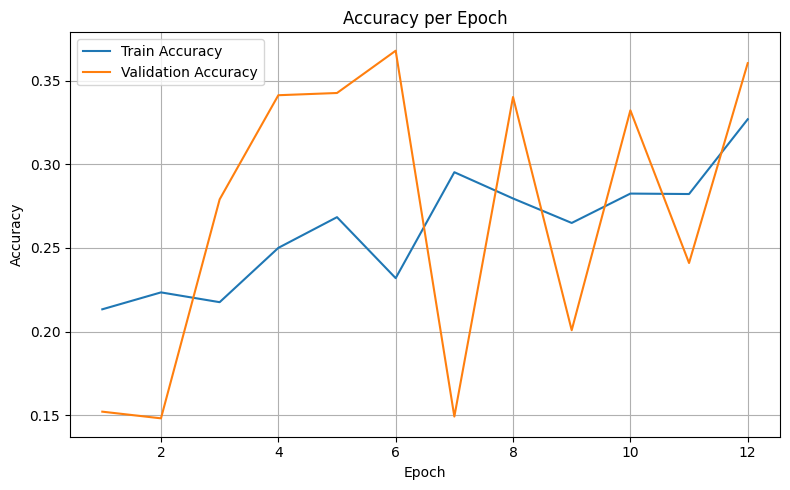

Training complete!


In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# Assuming the functions and variables like `TextDataset`, `collate_fn`, `load_data`, `EMBEDDING_DIM`, and `device` are already defined

# Create DataLoader
def dataloader_from_json(filename):
    sentences = load_data(filename)
    dataset = TextDataset(sentences)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    return dataloader

train_filename = "/kaggle/input/gender-based-abuse-dataset/final_train.json"
val_filename = "/kaggle/input/gender-based-abuse-dataset/final_test.json"
train_dataloader = dataloader_from_json(train_filename)
val_dataloader = dataloader_from_json(val_filename)

# Define RNN Model
import torch.nn as nn
import torch.nn.functional as F

class BiLSTMAttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(BiLSTMAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = True

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                            batch_first=True, bidirectional=self.bidirectional)
        
        # Attention layer parameters
        self.attention = nn.Linear(hidden_dim * 2, 1)  # *2 because BiLSTM
        
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch_size, seq_len, hidden_dim * 2]

        # Attention weights: [batch_size, seq_len, 1]
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)

        # Apply attention: [batch_size, hidden_dim * 2]
        context = torch.sum(attn_weights * lstm_out, dim=1)

        context = self.layer_norm(context)
        output = self.sigmoid(self.fc(context))
        return output

# Initialize Model
model = RNNClassifier(input_dim=EMBEDDING_DIM, hidden_dim=128, output_dim=3).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Loop
num_epochs = 12

# Lists to store accuracy for each epoch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    for batch, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float().cpu().numpy()
        true_labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(true_labels)

    train_f1 = f1_score(all_labels, all_preds, average="macro")
    train_acc = accuracy_score(all_labels, all_preds)

    train_f1s.append(train_f1)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    val_loss = 0

    with torch.no_grad():
        for batch, labels in val_dataloader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float().cpu().numpy()
            true_labels = labels.cpu().numpy()

            val_preds.extend(preds)
            val_labels.extend(true_labels)

    val_f1 = f1_score(val_labels, val_preds, average="macro")
    val_acc = accuracy_score(val_labels, val_preds)

    val_f1s.append(val_f1)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {epoch_loss:.4f}, Train Acc = {train_acc:.4f}, Train F1 = {train_f1:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}")

# Plot Accuracy Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/accuracy_plot.png")  # Save plot if on Kaggle
plt.show()

torch.save(model, "/kaggle/working/gbad_model_bilstm.pth")
print("Training complete!")




In [39]:

import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load tokenizer and embedding model (same as training)
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
embedding_model = AutoModelForMaskedLM.from_pretrained("google/muril-base-cased").get_input_embeddings()
EMBEDDING_DIM = embedding_model.embedding_dim

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("/kaggle/working/gbad_model_rnn.pth", map_location=device)
model.eval()

def predict_label(sentence, model, embedding_model):
    model.eval()

    # Tokenize sentence and convert to input IDs
    token_ids = tokenizer.encode(sentence, add_special_tokens=False)
    input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)

    # Move embedding model to correct device
    embedding_model = embedding_model.to(device)

    # Get embedding representation
    with torch.no_grad():
        embedded = embedding_model(input_ids)  # shape: [1, seq_len, embed_dim]

    # Run through RNN classifier model
    with torch.no_grad():
        output = model(embedded)  # shape: [1, 3]

    # Convert output to binary predictions
    predicted_labels = (output > 0.5).int().cpu().numpy()[0]
    return predicted_labels

# Test example
mysentence = "i love animals"
predicted = predict_label(mysentence, model, embedding_model)
print("Predicted Labels:", predicted)



Some weights of the model checkpoint at google/muril-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_31/1392210089.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com

Predicted Labels: [0 0 0]


In [38]:

summary(model, input_size=(32,50,EMBEDDING_DIM ))



Layer (type:depth-idx)                   Output Shape              Param #
RNNClassifier                            [32, 3]                   --
├─LSTM: 1-1                              [32, 50, 128]             459,776
├─LayerNorm: 1-2                         [32, 128]                 256
├─Linear: 1-3                            [32, 3]                   387
├─Sigmoid: 1-4                           [32, 3]                   --
Total params: 460,419
Trainable params: 460,419
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 735.66
Input size (MB): 4.92
Forward/backward pass size (MB): 1.67
Params size (MB): 1.84
Estimated Total Size (MB): 8.43